In [1]:
import sys, os
parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
import tool

import scipy, random
import pandas as pd
import numpy as np

%matplotlib widget
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Data Import
"""
asset_index = pd.read_csv("../data/AIDX.csv", encoding='gbk')

# data sorting
grouped_asset = asset_index.groupby("S_IRDCODE")
asset_dfs = {ird_code: group for ird_code, group in grouped_asset if len(group) >= 200}
for ird_code, grouped_df in asset_dfs.items():
    grouped_df['TRADE_DT'] = pd.to_datetime(grouped_df['TRADE_DT'], format='%Y%m%d')
    grouped_df.sort_values(by='TRADE_DT', inplace=True)



In [3]:
"""
Parameters
"""

BACKTEST_DAY = 30
MODEL_TYPE = 'MVO' # MVO, RP, BL, RB
TARGET_RETURN = 0.0 # target return
RISK_FREE_RATE = 0.02 # risk-free rate
NUM_ITERATION = 100
NUM_LIMIT = np.random.randint(*(5,10))
REBALANCE_DAYS = [10, 20, 30, 60, 90]

In [4]:
"""
Rebalancing
"""

def rebalance(asset_index, T, N, weight_constraints):
    predicts = []
    actuals = []
    realities = []
    
    for i in range(T, len(asset_index), T):
        
        if i+T >= len(asset_index):
            break
        
        historical_data = asset_index[i-T:i]
        future_data = asset_index[i:i+T]
        
        predict, actual = tool.evaluate(historical_data, future_data, weight_constraints, MODEL_TYPE, TARGET_RETURN, RISK_FREE_RATE)
        predicts.append(predict)
        actuals.append(actual)
        
        reality = tool.check([1 / N for _ in range(N)], future_data, RISK_FREE_RATE)  # equally weighed
        realities.append(reality)
    
    return predicts, actuals, realities

In [5]:
"""
Calculate Spearman Correlation
"""

def spearman_corr(L1, L2):
    
    a1, b1, c1 = zip(*L1)
    a2, b2, c2 = zip(*L2)
    
    return_corr, _ = scipy.stats.spearmanr(a1, a2)
    volatility_corr, _ = scipy.stats.spearmanr(b1, b2)
    sharpe_corr, _ = scipy.stats.spearmanr(c1, c2)
    
    return return_corr, volatility_corr, sharpe_corr

In [6]:
"""
One rebalance's iteration
"""

def one_rebalance(num_iteration, rebalance_day, asset, num_limit):
    return_corrs = []
    volatility_corrs = []
    sharpe_corrs = []

    for i in range(0, num_iteration):
        asset_index = asset.copy()
        
        index_list = random.sample(list(asset_dfs.keys()), num_limit)
        
        asset_index['TRADE_DT'] = pd.to_datetime(asset_index['TRADE_DT'], format='%Y%m%d')
        asset_index.sort_values(by='TRADE_DT', inplace=True)
        asset_index.set_index('TRADE_DT', inplace=True)
        asset_index = asset_index.pivot(columns='S_IRDCODE', values='CLOSE').ffill()[index_list].dropna()

        n = len(index_list)
        index_min_weight = [0 for _ in range(n)]
        index_max_weight = [1 for _ in range(n)]
        weight_constraints = list(zip(index_min_weight, index_max_weight))
        
        predicts, actuals, realities = rebalance(asset_index, rebalance_day, n, weight_constraints)
        return_corr, volatility_corr, sharpe_corr = spearman_corr(predicts, actuals)
        
        return_corrs.append(return_corr)
        volatility_corrs.append(volatility_corr)
        sharpe_corrs.append(sharpe_corr)
    
    return return_corrs, volatility_corrs, sharpe_corrs
    
    

In [7]:
"""
Multi rebalance iteration
"""

def rebalance_iteration(rebalance_periods, num_iteration, asset_index, num_limit):
    results = {}
    
    for rebalance_day in rebalance_periods:
        asset = asset_index.copy()
        return_corrs, volatility_corrs, sharpe_corrs = one_rebalance(num_iteration, rebalance_day, asset, num_limit)
        results[rebalance_day] = (return_corrs, volatility_corrs, sharpe_corrs)
    
    return results

results = rebalance_iteration(REBALANCE_DAYS, NUM_ITERATION, asset_index, NUM_LIMIT)
print(results)

{10: ([0.15316205533596838, -0.2816205533596838, 0.021739130434782608, 0.04893722792645219, 0.09486166007905138, 0.09587348946009576, -0.1324110671936759, 0.1590909090909091, 0.10375494071146245, -0.22826086956521738, -0.21349148168433696, 0.10177865612648221, -0.008893280632411068, -0.044466403162055336, -0.02075098814229249, -0.15217391304347824, 0.011857707509881422, 0.049407114624505935, -0.048418972332015815, 0.015810276679841896, 0.13738572200982793, 0.04644268774703557, 0.16901408966676676, 0.11462450592885376, 0.07114624505928854, -0.044466403162055336, 0.21156700558102565, 0.158102766798419, 0.07561156642986934, -0.08011873355441927, 0.12450592885375496, 0.02472800418346274, 0.024703557312252968, -0.03656126482213439, -0.04051383399209487, 0.1492094861660079, 0.03162055335968379, -0.11860637871352052, 0.0034593527124776816, 0.08506433439111181, 0.1274703557312253, 0.019762845849802375, -0.049407114624505935, -0.09142575025833874, 0.08893280632411067, 0.09142575025833874, 0.051

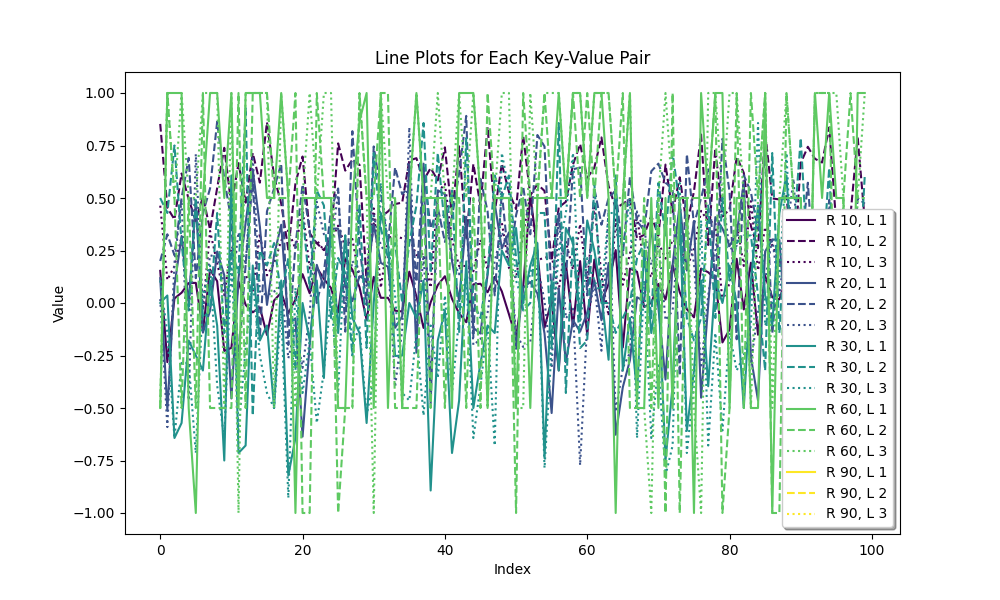

In [8]:
"""
Visualisation
"""

def display(data):
    line_styles = ['-', '--', ':']
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))

    fig, ax = plt.subplots(figsize=(10, 6))
    lines = []

    for (key, lists), color in zip(data.items(), colors):
        for i, lst in enumerate(lists):
            line, = ax.plot(lst, line_styles[i], color=color, label=f'R {key}, L {i+1}')
            lines.append(line)

    leg = ax.legend(fancybox=True, shadow=True)

    lined = {}
    for legline, origline in zip(leg.get_lines(), lines):
        legline.set_picker(5)
        lined[legline] = origline

    def on_pick(event):
        legline = event.artist
        origline = lined[legline]
        visible = not origline.get_visible()
        origline.set_visible(visible)

        legline.set_alpha(1.0 if visible else 0.2)
        fig.canvas.draw()

    fig.canvas.mpl_connect('pick_event', on_pick)

    ax.set_title('Line Plots for Each Key-Value Pair')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    plt.show()

display(results)